In [1]:
import os

In [ ]:

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import cityscapes_labels
import utils

from models import *
from keras import losses, metrics, optimizers
from loss import precision, dice_coef


Using TensorFlow backend.


In [ ]:
!nvidia-smi

In [3]:
#target_height, target_width = 360, 480
#target_height, target_width = 360, 648
target_height, target_width = 384, 640

import config


labels = cityscapes_labels.labels
n_classes = len(labels)
batch_size = 2
epochs = 10

dataset_path = config.data_path('gta')
images_path = os.path.join(dataset_path, 'images/')
labels_path = os.path.join(dataset_path, 'labels/')

# segnet
model = MobileUNet((target_height, target_width), n_classes)


#model.k.load_weights('weights/SegNet_2018_02_02_11:44_(200)_finished.h5')
model.k.load_weights('weights/MobileUNet_2018_02_13_23:26_cat_acc-0.87.hdf5')

model.summary()

model.k.compile(
    loss=losses.categorical_crossentropy,
    optimizer=optimizers.Adam(lr=0.001),
    metrics=[
        dice_coef,
        precision,
        metrics.categorical_accuracy
    ]
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 640, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 192, 320, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv_0_bn (BatchNormalization)  (None, 192, 320, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
conv_0_relu (Activation)        (None, 192, 320, 32) 0           conv_0_bn[0][0]                  
__________________________________________________________________________________________________
conv_dw_1 

In [ ]:
!ls weights

(0, '/storage/brno7-cerit/home/mlyko/data/gta/images/00003.png')
(1052, 1914, 3)
1/1 [==============================] - 1s 1s/step
(1, '/storage/brno7-cerit/home/mlyko/data/gta/images/00005.png')
(1052, 1914, 3)
1/1 [==============================] - 0s 117ms/step
(2, '/storage/brno7-cerit/home/mlyko/data/gta/images/00008.png')
(1052, 1914, 3)
1/1 [==============================] - 0s 115ms/step


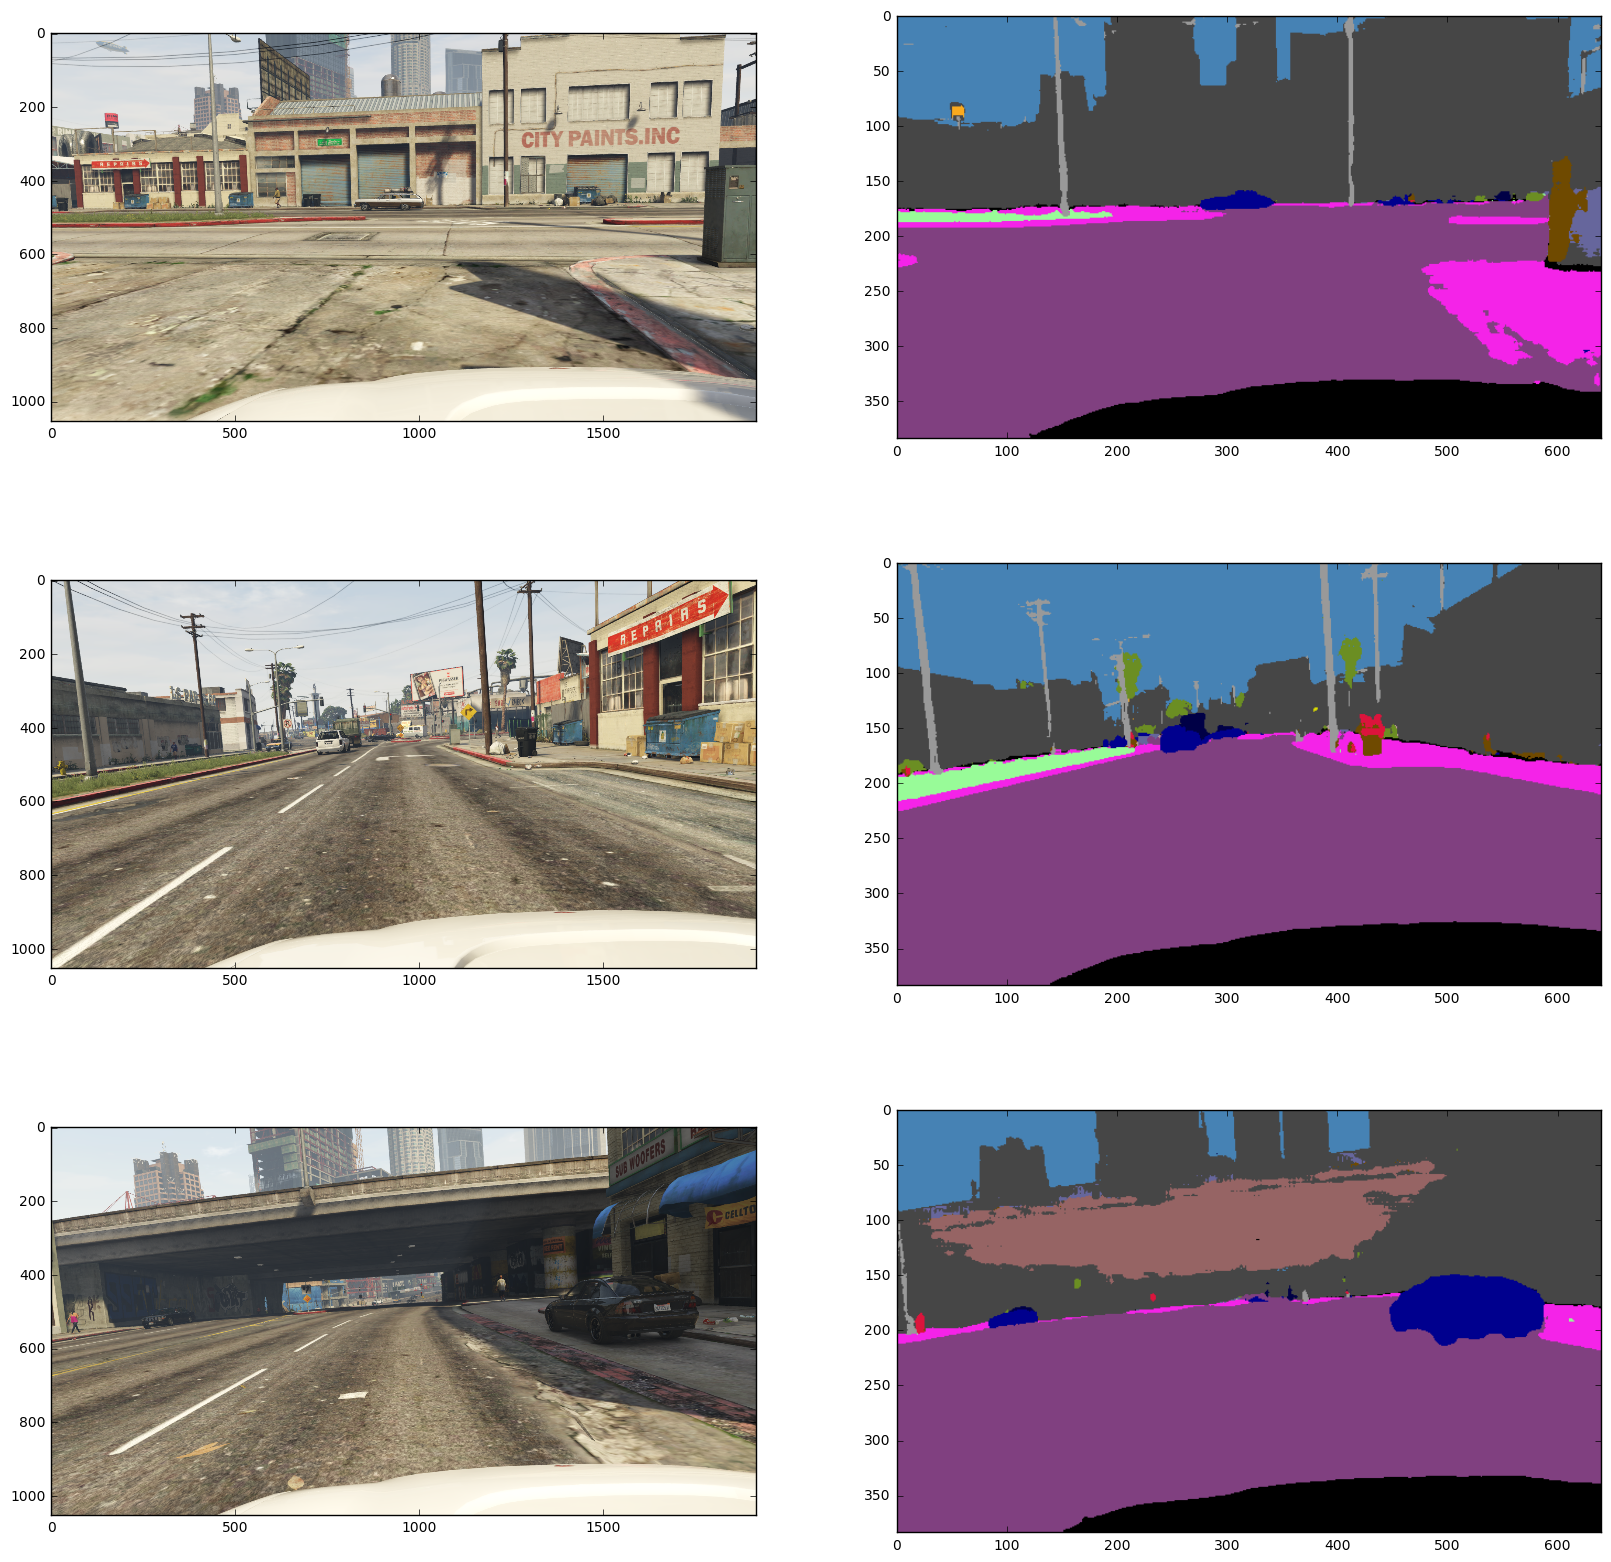

In [5]:
import data_generator
import cityscapes_labels

# testing set!
#predict_filenames = [
#    images_path + '00001.png',
#    images_path + '22001.png',
#    './results/cityscapes_2_img.png',
#    './results/exp1_camvid.png',
#    './results/img_aachen_000007_000019_leftImg8bit.png.png'
#]
#

predict_filenames = [
     images_path + '00003.png',
     images_path + '00005.png',
     images_path + '00008.png',
]

f, arr= plt.subplots(len(predict_filenames),2)
f.set_size_inches(20,20)

for i, filename in enumerate(predict_filenames):
    print(i, filename)

    image = cv2.imread(filename)

    print(image.shape)

    norm = data_generator.SimpleSegmentationGenerator.normalize(image, (target_height,target_width))

    prediction = model.k.predict(np.array([norm]), batch_size, verbose=1)

    class_scores = prediction.reshape((target_height, target_width, n_classes))
    class_image = np.argmax(class_scores, axis=2)
    colored_class_image = utils.class_image_to_image(class_image, cityscapes_labels.trainId2label)  # there should be trainid2label

    predicting_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    arr[i][0].imshow(predicting_image)
    arr[i][1].imshow(colored_class_image)

    im_to_save = cv2.cvtColor(colored_class_image, cv2.COLOR_RGB2BGR)

    cv2.imwrite('results/img_'+str(filename.split('/')[-1])+'.png', image)
    cv2.imwrite('results/pred_'+ str(filename.split('/')[-1])+'.png', im_to_save)

In [ ]:
# test visualize
import keras.backend as K

predict_filenames = [
     images_path + '00003.png',
#     images_path + '00005.png',
#     images_path + '00008.png',
]

#f, arr= plt.subplots(len(predict_filenames),2)
#f.set_size_inches(20,20)


def layer_to_visualize(img_to_visualize, layer, model):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)
    convolutions=np.moveaxis(convolutions, 2, 0)
    print ('Shape of conv:', convolutions.shape)
    
    filters = convolutions.shape[0]
    print("convs", filters)
    n = int(np.ceil(np.sqrt(filters)))
#    print("sqrted", n)
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(32,32))
    for i in range(filters):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i], cmap='rgb')


In [ ]:
for i, filename in enumerate(predict_filenames):
    print(i, filename)

    image = cv2.imread(filename)

    print(image.shape)

    norm = data_generator.SimpleSegmentationGenerator.normalize(image, (target_height,target_width))

#    to_vis = np.array([norm])
    to_vis = np.expand_dims(norm, axis=0)
    print(to_vis.shape)
    
    layer_to_visualize(to_vis, model.k.get_layer('conv_pw_5_relu'), model.k)    
    
    layer_to_visualize(to_vis, model.k.get_layer('conv_pw_13_relu'), model.k)    

    layer_to_visualize(to_vis, model.k.get_layer('conv2d_transpose_1'), model.k)    
    layer_to_visualize(to_vis, model.k.get_layer('conv2d_transpose_4'), model.k)    

In [ ]:
!pwd